# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as word2Vec or a simple td-idf on the papers.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Setup

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/My Drive/CORD-19-research-challenge/')
os.listdir()

['noncomm_use_subset',
 'custom_license',
 'comm_use_subset',
 'biorxiv_medrxiv',
 'metadata.readme',
 'COVID.DATA.LIC.AGMT.pdf',
 'json_schema.txt',
 '.DS_Store',
 'metadata.csv']

## Install packages 

# Import packages

In [0]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain
import mpld3
import mplcursors
from collections import  namedtuple

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec, Doc2Vec
from gensim.utils import simple_preprocess

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
#from sentence_transformers import SentenceTransformer
import transformers

from rank_bm25 import BM25Okapi

## Download the stopwords and special characters

In [31]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


# Data processing

### Collect json files from the attached drive

In [0]:
metadata_df = pd.read_csv('./metadata.csv')  

In [48]:
metadata_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [0]:
filepath_biorxiv = './biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = './noncomm_use_subset/noncomm_use_subset'
filepath_comm = './comm_use_subset/comm_use_subset'
filepath_custom = './custom_license/custom_license'

all_json_files = glob.glob(f'**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'custom_license/**/*.json', recursive=True)


# Collect json files from the local machine

In [0]:
# enumerate json files
all_json_files = glob.glob(f'data/**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'data/biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'data/noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'data/comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'data/custom_license/**/*.json', recursive=True)

In [0]:
# get all paths
filepath_biorxiv = '.data/biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = '.data/noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = '.data/custom_license/custom_license'

### Create dictionary
Create a dictionary with the plain texts, indexing all papers with it's ID, store dictionary as json

In [0]:
metadata_df = pd.read_csv('data/metadata.csv')

In [0]:
# convert metadata_df to numpy array
metadata_np = np.array(metadata_df)

# extract the indecies of important properties
cord_uid_index = metadata_df.columns.get_loc("cord_uid")
sha_index = metadata_df.columns.get_loc("sha")
title_index = metadata_df.columns.get_loc("title")
abstract_index = metadata_df.columns.get_loc("abstract")
authors_index = metadata_df.columns.get_loc("authors")
journal_index = metadata_df.columns.get_loc("journal")
publish_time_index = metadata_df.columns.get_loc("publish_time")
has_pdf_parse_index = metadata_df.columns.get_loc("has_pdf_parse")
full_text_file_index = metadata_df.columns.get_loc("full_text_file")
url_index = metadata_df.columns.get_loc("url")

In [0]:
paper_dict = {}
for i in range(metadata_np.shape[0])[0:1000]:
    # extract body text from json file if possible
    has_pdf_parse = metadata_np[i][has_pdf_parse_index]
    if has_pdf_parse:
        full_text_file = metadata_np[i][full_text_file_index]
        sha = metadata_np[i][sha_index]

        json_file_glob = 'data/{0}/**/{1}.json'.format(full_text_file, sha)
        paper = glob.glob(json_file_glob, recursive=True)
        
        body_text = ''
        try:
            with open(os.path.join(paper[0])) as json_file:
                paper_json = json.load(json_file)
                body_text = concat_json_properties(paper_json['body_text'], 'text')
        except:
            pass
        
    # create dict
    paper_dict[metadata_np[i][cord_uid_index]] = {
        'sha': sha,
        'title': metadata_np[i][title_index],
        'authors': metadata_np[i][authors_index],
        'abstract': metadata_np[i][abstract_index],
        'body_text': body_text,
        'publish_date': metadata_np[i][publish_time_index],
        'journal': metadata_np[i][journal_index],
        'url': metadata_np[i][url_index],
    }

with open('paper_dict.json', 'w') as fw:
    json.dump(paper_dict, fw, indent=2)

Load the dictionary from the json file

In [0]:
paper_dict = {}
with open('paper_dict.json', 'r') as fp:
    paper_dict = json.load(fp)

## Helper functions

In [0]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
      if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
          continue
      filtered_list.append(token)
    return filtered_list

In [0]:
def get_preprocessed_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
        
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        preprocessed_text_ = preprocessing(str(text))
        preprocessed_text.append(preprocessed_text_)
        
  return preprocessed_text

In [0]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        try:
            text = concat_json_properties_as_string(json_object[attribute], 'text')
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        except:
            pass
        
  return preprocessed_tokenized_sentences

In [0]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        if text != '':
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        
  return preprocessed_tokenized_sentences

In [0]:
def get_section_text(body_text, section_name_pattern):
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            return section['text']
        else:
            return 'none'

In [0]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [0]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [0]:
def visualize_word_frequencies(feature):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

# Dataset analysis

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications of papers

The dataset contains research papers that have been published in various journals

In [66]:
journal_names = get_dict_element_by_key('journal')
        
values, counts = np.unique(journal_names, return_counts=True)
print(values)
print(counts)


['AIDS Res Ther' 'Acta Crystallogr D Biol Crystallogr' 'Acta Vet Scand'
 'Adv Bioinformatics' 'Ann Clin Microbiol Antimicrob' 'Ann Thorac Med'
 'Annals of Botany' 'Arch Virol' 'Arthritis Res Ther' 'Asia Pac Fam Med'
 'Aust New Zealand Health Policy' 'BMC Bioinformatics' 'BMC Biol'
 'BMC Biotechnol' 'BMC Cell Biol' 'BMC Dev Biol' 'BMC Evol Biol'
 'BMC Fam Pract' 'BMC Gastroenterol' 'BMC Genomics' 'BMC Health Serv Res'
 'BMC Immunol' 'BMC Infect Dis' 'BMC Med' 'BMC Med Ethics' 'BMC Med Genet'
 'BMC Med Genomics' 'BMC Med Inform Decis Mak' 'BMC Med Res Methodol'
 'BMC Microbiol' 'BMC Mol Biol' 'BMC Musculoskelet Disord' 'BMC Physiol'
 'BMC Plant Biol' 'BMC Pregnancy Childbirth' 'BMC Public Health'
 'BMC Pulm Med' 'BMC Res Notes' 'BMC Struct Biol' 'BMC Vet Res' 'BMJ'
 'Biochemistry' 'Biol Proced Online' 'Biology of Reproduction'
 'Biomolecular NMR Assignments' 'Biotechnol J' 'Br J Cancer' 'Brain'
 'Brain Pathol' 'Case Rep Med' 'Cases J' 'Cell Death & Differentiation'
 'Cell Microbiol' 'Cli

In [72]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of the publishing years")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

mplcursors.cursor(hover=True)

plt.show()

<IPython.core.display.Javascript object>

## Topics

The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. 

Achieving compliance with the International Health Regulations by overseas territories of the United Kingdom of Great Britain and Northern Ireland
Epidemiology of respiratory viral infections in people with acute respiratory tract infections in Africa: the VARIAFRICA systematic review and meta-analysis protocol
Prediction of cross-species infection propensities of viruses with receptor similarity
A comparative analysis of host responses to avian influenza infection in ducks and chickens highlights a role for the interferon-induced transmembrane proteins in viral resistance
Emerging infectious disease outbreaks: Old lessons and new challenges for obstetrician-gynecologists
Assessment of returning travellers with fever
Anti-Norovirus Therapeutics: A Patent Review (2010-2015)
Choindroitinase ABC I-Mediated Enhancement of Oncolytic Virus Spread and Anti Tumor Efficacy: A Mathematical Model
Alzheimer's disease Advax CpG - adjuvanted MultiTEP-based dual and single vaccines induce high- titer

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


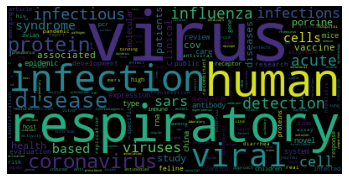

In [0]:
titles = get_dict_element_by_key('title')

titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

topics = []
for title in titles:
  topics.extend(preprocessing(title, ['title', 'using', 'analysis']))

visualize_word_frequencies(topics)

In [0]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

# TODO: create clustering of title sbased on cosine similarity and visualize them (-> see https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Interactive-t-SNE

## Visualize the word frequencies

In [68]:
preprocessed_biorxiv_abstract_text = get_preprocessed_text_from_files(biorxiv_json_files, 'abstract')

visualize_word_frequencies(chain(*preprocessed_biorxiv_abstract_text))

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


<IPython.core.display.Javascript object>

In [0]:
noncomm_biorxiv_abstract_text = get_preprocessed_text_from_files(noncomm_json_files, 'abstract')

visualize_word_frequencies(chain(*noncomm_biorxiv_abstract_text))

# Build word2vec models for the data sets

In [74]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=biorxiv_abstracts,
    window=10,
    min_count=2,
    workers=10)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [75]:
biorxiv_model.most_similar('immunity')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('required', 0.999791145324707),
 ('elements', 0.9997739791870117),
 ('hla', 0.9995725154876709),
 ('culture', 0.999563992023468),
 ('containing', 0.9995620250701904),
 ('recombination', 0.9995484352111816),
 ('canonical', 0.9995423555374146),
 ('pv', 0.9995337128639221),
 ('vivo', 0.9995306134223938),
 ('acting', 0.9995243549346924)]

In [77]:
biorxiv_model.most_similar('covid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wuhan', 0.9981735944747925),
 ('china', 0.9975823163986206),
 ('mainland', 0.9966127872467041),
 ('confirmed', 0.9953258633613586),
 ('january', 0.9946770668029785),
 ('hubei', 0.9933284521102905),
 ('fatality', 0.9927977919578552),
 ('patients', 0.9918888807296753),
 ('officially', 0.991870641708374),
 ('shenzhen', 0.990192711353302)]

In [79]:
biorxiv_model.most_similar('distancing')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('contact', 0.9976701736450195),
 ('beds', 0.9966877698898315),
 ('tracing', 0.9964783191680908),
 ('isolation', 0.9963631629943848),
 ('lock', 0.9953387975692749),
 ('diagnoses', 0.9952039122581482),
 ('fit', 0.995118260383606),
 ('serial', 0.9950934052467346),
 ('closure', 0.9949992895126343),
 ('mean', 0.9943912029266357)]

Do the same thing on all papers, compare results

In [80]:
# collect all abstracts from the data biorxiv data set
all_abstracts = get_preprocessed_sentences_from_files(all_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=all_abstracts,
    window=10,
    min_count=2,
    workers=10)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [81]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in biorxiv_model.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(biorxiv_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [0]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [84]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10,7))
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    
    mplcursors.cursor(hover=True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

    
tsne_plot_similar_words('Similar words from Biorxiv data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

<IPython.core.display.Javascript object>

# Doc2Vec

In [87]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [95]:
# create documents
documents = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(analyzedDocument(preprocessed_sentences, tags))

# train the model
model = Doc2Vec(documents, size=100, window=300, min_count=1, workers=4)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [96]:
# query the model
query = "What is known about transmission, incubation, and environmental stability".split()

query_vector = model.infer_vector(query)
similar_abstracts = model.docvecs.most_similar([query_vector])

for doc_tags in similar_abstracts:
    abstract = paper_dict[doc_tags[0]]['abstract']
    print(doc_tags[1])
    print(abstract)

0.9287121891975403
BACKGROUND: Microbial forensics is important in tracking the source of a pathogen, whether the disease is a naturally occurring outbreak or part of a criminal investigation. RESULTS: A method and SPR Opt (SNP and PCR-RFLP Optimization) software to perform a comprehensive, whole-genome analysis to forensically discriminate multiple sequences is presented. Tools for the optimization of forensic typing using Single Nucleotide Polymorphism (SNP) and PCR-Restriction Fragment Length Polymorphism (PCR-RFLP) analyses across multiple isolate sequences of a species are described. The PCR-RFLP analysis includes prediction and selection of optimal primers and restriction enzymes to enable maximum isolate discrimination based on sequence information. SPR Opt calculates all SNP or PCR-RFLP variations present in the sequences, groups them into haplotypes according to their co-segregation across those sequences, and performs combinatoric analyses to determine which sets of haplotype

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# BM25 Index

In [110]:
# create documents
documents = []
paper_ids = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(preprocessed_sentences)
    paper_ids.append(paper_id)

# train the model
bm25_model = BM25Okapi(documents)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [98]:
def search(search_query, num_results=10):
    preprocessed_search_query = preprocessing(search_query)
    scores = bm25_model.get_scores(preprocessed_search_query)
    top_indexes = np.argsort(scores)[::-1][0:num_results]
    return top_indexes

indexes = search('What is known about transmission, incubation, and environmental stability')
for index in indexes:
    paper_id = paper_ids[index]
    print(paper_dict[paper_id]['abstract'])

The incubation period of infectious diseases, the time from infection with a microorganism to onset of disease, is directly relevant to prevention and control. Since explicit models of the incubation period enhance our understanding of the spread of disease, previous classic studies were revisited, focusing on the modeling methods employed and paying particular attention to relatively unknown historical efforts. The earliest study on the incubation period of pandemic influenza was published in 1919, providing estimates of the incubation period of Spanish flu using the daily incidence on ships departing from several ports in Australia. Although the study explicitly dealt with an unknown time of exposure, the assumed periods of exposure, which had an equal probability of infection, were too long, and thus, likely resulted in slight underestimates of the incubation period. After the suggestion that the incubation period follows lognormal distribution, Japanese epidemiologists extended thi

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


# Implement a BERT search engine 

In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                  "How long can the 2019-nCoV virus remain viable on common surfaces?"
              ]
query_embeddings = model.encode(queries)

In [0]:
text = ''.join([str(i) for i in documents])

In [0]:
abstract_embeddings = model.encode(text)

print(abstract_embeddings)

# Implement a BERT summarizer

In [0]:
from summarizer import Summarizer
model = Summarizer()

Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity and summarize their contents

In [16]:
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        result = model(df_noncomm['text'][idx], min_length=60)
        full = ''.join(result)
        print(df_noncomm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")
        print("\nSummary of the paper containing the sentence: ", full, "\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 
(Score: 0.7361) 


Summarization of the paper containing the sentence:  To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 

Ebolaviruses constitute a public health threat, particularly in Central and Western Africa. Host cell factors required for spread of ebolaviruses may serve as targets for antiviral intervention. Lectins, TAM receptor tyrosine kinases (Tyro3, Axl, Mer), T cell immunoglobulin and mucin domain (TIM) proteins, integrins, and Niemann-Pick C1 (NPC1) have been reported to promote entry of ebolaviruses into certain cellular systems. However, the factors used by ebolaviruses to invade macrophages, major viral targe

Another BERT pretrained Q&A

In [0]:
import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)
#model.eval()


In [19]:

question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"

input_ids = tokenizer.encode(question, text)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

print(answer)


a nice puppet
